# Exploring AirBnB in Athens

A lot has been said and written about the effect of AirBnB in Athens. In this assignment, you will use the data collected by [Inside AirBnB](http://insideairbnb.com), so you can go ahead and download the Athens data from http://insideairbnb.com/get-the-data.html.

Once you do that, spend some time familiarizing yourself with the data and then go ahead and do the following tasks.

## Neighbourhood Listings in Descending Order

Show the listings per neighbourghood, with the most popular neighbourhoods first (that is, in decreasing neighbourhood popularity order).

We start by examining the Data Dictionary file from the website in order to undersand better the data itself. 
After that, we are using the libraries $\textit{requests}$ and $\textit{BeautifulSoup}$ to fetch the data automatically to the working directory.


In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
URL = 'http://insideairbnb.com/get-the-data.html'

try:
    # Try to get the webpage content
    response = requests.get(URL)
    response.raise_for_status()  # Raise an exception if the response was unsuccessful

    # Parse the content with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the proper link for the Athens listings data
    athens_link = None
    for link in soup.find_all('a', href=True):
        if 'athens' in link['href'] and 'listings.csv.gz' in link['href']:
            athens_link = link['href']
            break

    if athens_link:
        print(f"Found the Athens data link: {athens_link}")
    else:
        print("Could not find the Athens data link.")

except requests.RequestException as e:
    print(f"Error fetching the page {URL}. Error message: {e}")
except Exception as e:
    print(f"An error occurred while processing. Error message: {e}")


Found the Athens data link: http://data.insideairbnb.com/greece/attica/athens/2023-09-21/data/listings.csv.gz


In [3]:
if athens_link:
    response = requests.get(athens_link, stream=True)
    with open('listings.csv.gz', 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192): #security for large files in memory storage
            file.write(chunk)
    print("Downloaded the Athens data.")
else:
    print("Athens data link is not available.")

Downloaded the Athens data.


To optimize performance and resource usage, it's a good idea to only fetch and process the columns we need from the data. Here's a breakdown of the columns we will use in the tasks below with a short description:

1. **Neighbourhood Listings**:
    - `neighbourhood_cleansed`: The number of listings per neighbourhood.
  
2. **Neighbourhood Prices**:
    - `neighbourhood_cleansed`: To group by neighbourhood.
    - `price`: To calculate median, mean, and standard deviation of prices.

3. **Availability per Day**:
    - This will be fetched from the calendar data.
  
4. **Reviews, Occupancy, and Income**:
    - `reviews_per_month`: To calculate occupancy and average reviews per month.
    - `price`: To calculate average income using average price.

5. **Listings per Room Type**:
    - `room_type`: To count listings by room type.
    - `neighbourhood_cleansed`: To categorize by neighbourhood.
  
6. **Prices per Day**:
    - This will be fetched by the calendar data.

7. **Listings per Host**:
    - `host_id`: To count the number of listings per host.

8. **Visualize Listings on a Map**:
    - `latitude` and `longitude`: To place each listing on the map.
    - `description`: To show a short description on the marker's popup.

In [4]:
import pandas as pd

# Columns needed from the listings dataset
needed_columns = [
    'neighbourhood_cleansed', 
    'price', 
    'number_of_reviews',
    'room_type', 
    'host_id', 
    'latitude', 
    'longitude', 
    'description'
]

data = pd.read_csv('listings.csv.gz', compression='gzip', usecols=needed_columns)
print(data.head(10))

                                         description  host_id  \
0  The apartment is 3-bedroom apartment with 2-ba...    37177   
1  Athens Quality Apartments - Deluxe apartment i...    37177   
2  The Studio is an <br />-excellent located <br ...    37177   
3  AQA No2 is 1-bedroom apartment (47m2), on the ...    37177   
4  Value for money in an central but not "tourist...  3745284   
5  Athens Quality Apartments -  Ground floor apar...    37177   
6  relaxed, quiet area, next to all historic and ...  2534881   
7  TOP 5 REASONS to stay here<br />⭐️Don't waste ...   121318   
8  Sleeping on a boat is the ultimate glamping ex...   133845   
9  Apartment located near metro station. Safe nei...   146553   

     neighbourhood_cleansed   latitude  longitude        room_type    price  \
0               ΑΜΠΕΛΟΚΗΠΟΙ  37.988630  23.765270  Entire home/apt  $144.00   
1               ΑΜΠΕΛΟΚΗΠΟΙ  37.989030  23.764480  Entire home/apt   $70.00   
2               ΑΜΠΕΛΟΚΗΠΟΙ  37.988880  23.7647

In [5]:
print(data.isna().sum()) #sanity chk to see the completeness of the dataframe.
#Weird enough, there are Nans only in "description" that don't matter as they will be used for folium part only,
#no calculations from it.

description               33
host_id                    0
neighbourhood_cleansed     0
latitude                   0
longitude                  0
room_type                  0
price                      0
number_of_reviews          0
dtype: int64


In [6]:
#data.shape #chk the number of listings

In [7]:
# Group by neighbourhood and count listings
neighbourhood_counts = data['neighbourhood_cleansed'].value_counts()

# Display top 20 in descending order
print(neighbourhood_counts.iloc[:20])

neighbourhood_cleansed
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ              2416
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ                 1122
ΝΕΟΣ ΚΟΣΜΟΣ                          980
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ             979
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ     817
ΠΛΑΤΕΙΑ ΑΤΤΙΚΗΣ                      583
ΠΑΓΚΡΑΤΙ                             511
ΑΜΠΕΛΟΚΗΠΟΙ                          452
ΚΟΛΩΝΑΚΙ                             425
ΘΗΣΕΙΟ                               386
ΑΚΡΟΠΟΛΗ                             386
ΠΕΤΡΑΛΩΝΑ                            352
ΚΕΡΑΜΕΙΚΟΣ                           343
ΚΥΨΕΛΗ                               271
ΣΤΑΔΙΟ                               252
ΓΟΥΔΙ                                230
ΙΛΙΣΙΑ                               216
ΠΛΑΤΕΙΑ ΑΜΕΡΙΚΗΣ                     180
ΝΙΡΒΑΝΑ                              174
ΠΑΤΗΣΙΑ                              166
Name: count, dtype: int64


## Neighbourhood Prices in Descending Order

Create a table with the prices per neighbourhood. The prices information should contain:

* median price per neighbourhood

* mean price per neighbourhood

* standard deviation per neighbourhood

* number of listings per neighbourhood.

The contents of the table should be in descending median prices.

In [8]:
# Convert price from string with $ and , to a float
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)

# Group by neighbourhood_cleansed and calculate median, mean, std, and count
grouped = data.groupby('neighbourhood_cleansed')['price'].agg(['median', 'mean', 'std', 'count'])

# Sort by median price in descending order
sorted_neighbourhoods = grouped.sort_values(by='median', ascending=False)

print(sorted_neighbourhoods.iloc[:20])

                          median        mean          std  count
neighbourhood_cleansed                                          
ΡΗΓΙΛΛΗΣ                   120.0  367.800000   578.622675      5
ΖΑΠΠΕΙΟ                    114.0  224.068323   641.163173    161
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ     104.0  140.650662   229.183015   2416
ΑΚΡΟΠΟΛΗ                   100.0  195.344560   703.321565    386
ΚΟΛΩΝΑΚΙ                   100.0  128.595294   104.431349    425
ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ         90.5  120.284314   104.613533   1122
ΘΗΣΕΙΟ                      90.0  126.492228   124.176775    386
ΚΕΡΑΜΕΙΚΟΣ                  89.0  123.883382   136.367487    343
ΛΥΚΑΒΗΤΤΟΣ                  75.0  104.561728    87.859850    162
ΓΚΑΖΙ                       70.5   95.792453    75.355882    106
ΣΤΑΔΙΟ                      70.0  121.515873   509.991840    252
ΙΛΙΣΙΑ                      70.0   87.189815    53.519013    216
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ    67.0  169.259448  2563.621548    979
ΝΕΟΣ ΚΟΣΜΟΣ              

## Availability per Day

Create a plot with the number of listings available per day, on the $y$ axis, and the date, on the $x$ axis.

In [9]:
# Fetch the calendar data from the given URL with a chk if there is internet connection or problems..

#URL = 'http://insideairbnb.com/get-the-data.html'

try:
    response = requests.get(URL)
    response.raise_for_status()  # Raise an exception if the response was unsuccessful

    # Parse the content with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the link for the Athens calendar data
    athens_calendar_link = None
    for link in soup.find_all('a', href=True):
        if 'athens' in link['href'] and 'calendar.csv.gz' in link['href']:
            athens_calendar_link = link['href']
            break

    if athens_calendar_link:
        response = requests.get(athens_calendar_link, stream=True)
        response.raise_for_status()  # Raise an exception if the response was unsuccessful

        # Save the data to a file
        with open('calendar.csv.gz', 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
                
        print("Downloaded the Athens calendar data.")

    else:
        print("Could not find the Athens calendar data link.")

except requests.RequestException as e:
    print(f"Error fetching the data. Error message: {e}")
except Exception as e:
    print(f"An error occurred. Error message: {e}")


Downloaded the Athens calendar data.


In [10]:
# Load the calendar data

import matplotlib.pyplot as plt

# Columns needed from the calendar dataset
needed_columns_calendar = ['date', 'available', 'price']

# Fetch only the required columns from the dataset
calendar_data = pd.read_csv('calendar.csv.gz', compression='gzip', usecols=needed_columns_calendar)

# Convert 'date' column to datetime type
calendar_data['date'] = pd.to_datetime(calendar_data['date'])

In [11]:
print(calendar_data.isna().sum()) #sanity chk to see the complitenes of the dataframe. Again no nans, strange...

date         0
available    0
price        0
dtype: int64


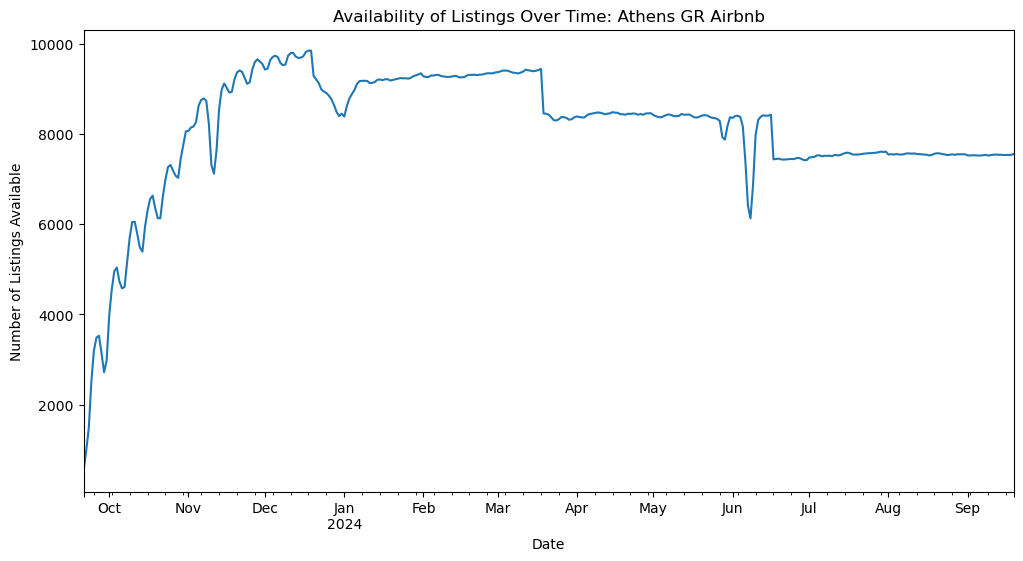

In [12]:
# Filter for available listings (availability is represented with "t" for true)
available_data = calendar_data[calendar_data['available'] == 't']

# Group by date and count listings
availability_per_day = available_data.groupby('date').size()

# Plotting
plt.figure(figsize=(12, 6))
availability_per_day.plot()
plt.ylabel('Number of Listings Available')
plt.xlabel('Date')
plt.title('Availability of Listings Over Time: Athens GR Airbnb')
plt.show()

## Reviews, Occupacy per Listing, Average Income

Create a histogram showing the number of reviews per listing. The histogram should bin the number of reviews, from the smallest amount of reviews in a listing, to the maximum number of reviews in a listing rounded up to the closest hundred.

Once you have done that, calculate the average occupacy per listing per month. To calculate that, find the average reviews per month and assume that half of the bookings result in reviews.

Then, assuming that each booking is for a three nights stay, calculate the average income per month, using the average price charged throughout all listings.

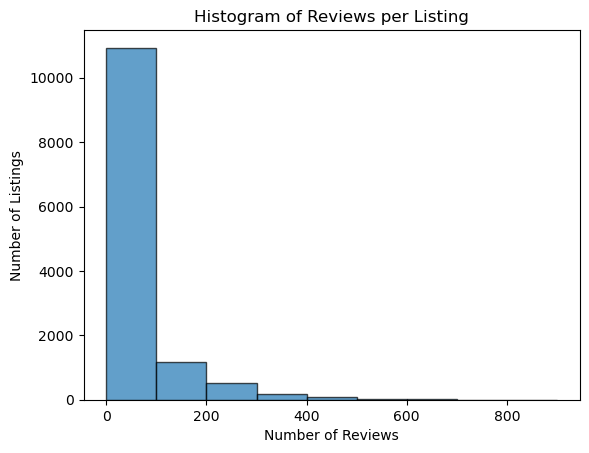

Average Occupancy per Listing per Month: 8.11241476907243
Average Income per Listing per Month: $ 2688.26


In [13]:
# Make the Histogram for Reviews per Listing
import numpy as np #use the numpy lib cause it has many nice goodies for calculations implemented in python from C

max_reviews = data['number_of_reviews'].max()
bins = np.linspace(0, np.ceil(max_reviews/100)*100, num=int(np.ceil(max_reviews/100))+1)

plt.hist(data['number_of_reviews'], bins=bins, edgecolor='k', alpha=0.7)
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Listings')
plt.title('Histogram of Reviews per Listing')
plt.show()

# Average Occupancy per Listing per Month
# Assuming half the bookings result in reviews and 1 review means 1 booking
avg_reviews_per_month = data['number_of_reviews'].mean() / 12  # Assuming the data spans one year
avg_occupancy_per_month = avg_reviews_per_month * 2  # Since half bookings result in reviews

print(f"Average Occupancy per Listing per Month: {avg_occupancy_per_month}")

# Average Income per Month
avg_price = data['price'].mean()
# Assuming 3 nights stay per booking
avg_income_per_month = avg_occupancy_per_month * 3 * avg_price

print(f"Average Income per Listing per Month: $ {avg_income_per_month:.2f}")


## Listings per Room Type

Show the number of listings per room type, in absolute numbers, and also in percentages (the percentage of listings for each particular room type). Then, show the number of listings per neighrbourhood and room type.

In [14]:
# Number of Listings per Room Type
room_type_counts = data['room_type'].value_counts()
print("Number of Listings per Room Type:\n", room_type_counts)

# Percentage of Listings per Room Type
total_listings = len(data)
room_type_percentage = (room_type_counts / total_listings) * 100
print("\nPercentage of Listings per Room Type:\n", room_type_percentage)

# Number of Listings per Neighbourhood and Room Type
neighbourhood_room_type_counts = data.groupby(['neighbourhood_cleansed', 'room_type']).size().unstack().fillna(0)
print("\nNumber of Listings per Neighbourhood and Room Type:\n", neighbourhood_room_type_counts)



Number of Listings per Room Type:
 room_type
Entire home/apt    11652
Private room        1113
Hotel room           105
Shared room           85
Name: count, dtype: int64

Percentage of Listings per Room Type:
 room_type
Entire home/apt    89.942107
Private room        8.591277
Hotel room          0.810498
Shared room         0.656117
Name: count, dtype: float64

Number of Listings per Neighbourhood and Room Type:
 room_type                         Entire home/apt  Hotel room  Private room  \
neighbourhood_cleansed                                                        
1Ο ΝΕΚΡΟΤΑΦΕΙΟ                               55.0         0.0           0.0   
ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ                             33.0         0.0           5.0   
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ            686.0         4.0         117.0   
ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ                               91.0         0.0           8.0   
ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ                            74.0         0.0           2.0   
ΑΚΡΟΠΟΛΗ                    

## Prices per Day

Create a table with the average price per listing per day. Draw a graph visualizing the table.

        date       price
0 2023-09-21  113.107689
1 2023-09-22  116.212290
2 2023-09-23  116.264860
3 2023-09-24  113.045932
4 2023-09-25  111.629226
5 2023-09-26  111.730585
6 2023-09-27  112.723792
7 2023-09-28  113.795816
8 2023-09-29  117.200942
9 2023-09-30  116.834414


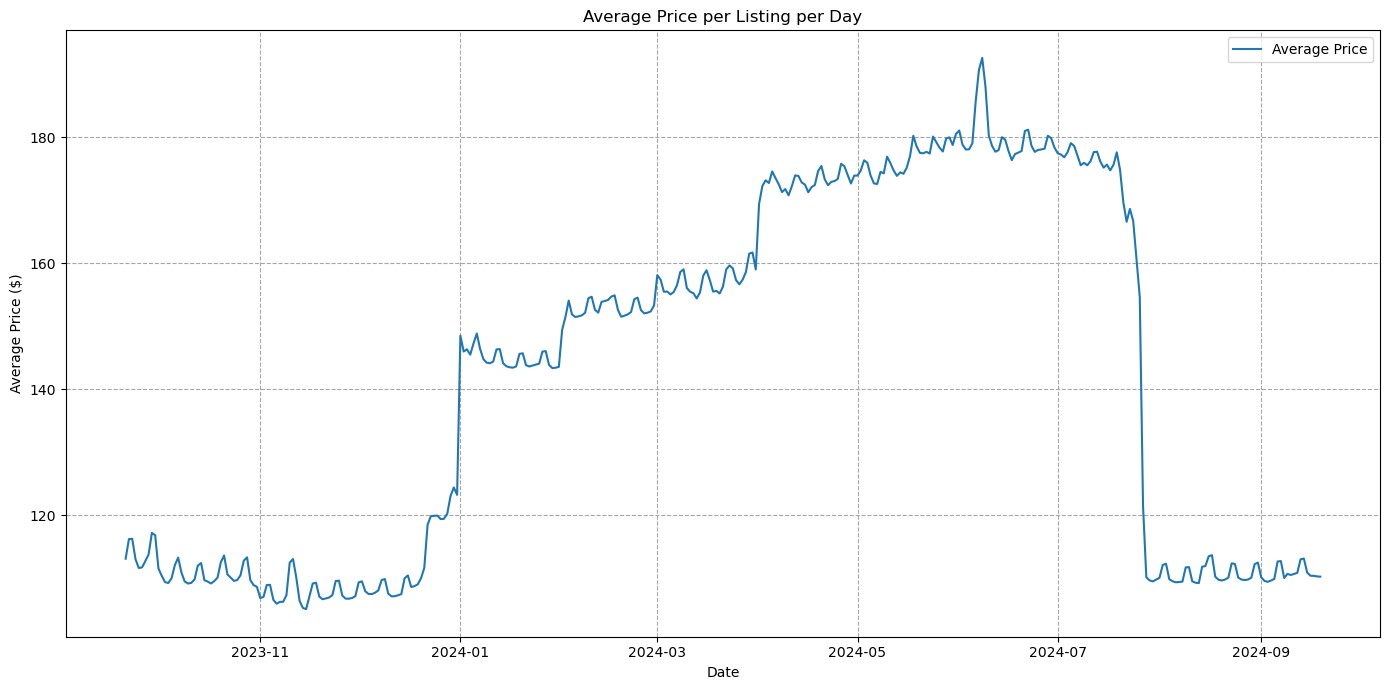

In [15]:
# Convert 'date' column to datetime type
calendar_data['date'] = pd.to_datetime(calendar_data['date'])

# Convert price from string with $ and , to a float
calendar_data['price'] = calendar_data['price'].replace('[\$,]', '', regex=True).astype(float)

# Calculating Average Price per Day

avg_price_per_day = calendar_data.groupby('date')['price'].mean()

# Convert result to DataFrame for easier visualization
avg_price_df = avg_price_per_day.reset_index()

# Display table (here, we're just displaying the first 10 rows for brevity)
print(avg_price_df.head(10))

# And finally Plotting the Data

plt.figure(figsize=(14, 7))
plt.plot(avg_price_df['date'], avg_price_df['price'], label='Average Price')
plt.title('Average Price per Listing per Day')
plt.xlabel('Date')
plt.ylabel('Average Price ($)')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.show()


## Listings per Host

Create a table with the number of listings per host, in descending order. Create a graph that will show the distribution of listings per host, as follows:

* You will rank the host on a number of listings basis. So, the first host will be the one with the largest number of listings, the second host will be the one with the second largest number of listings, etc. If there is a number of hosts with the same listings, just add them in sequence. For instance, if there are 10 hosts with one listing each, add them in the ranking with any order between them.

* On the $y$ axis you will have the number of listings.

That is, a point $(x, y)$ will mean that the $x$-th highest hosting host has $y$ listings.

After you have drawn the plot, do another one, this time with the $x$ axis in *logarithmic* scale.

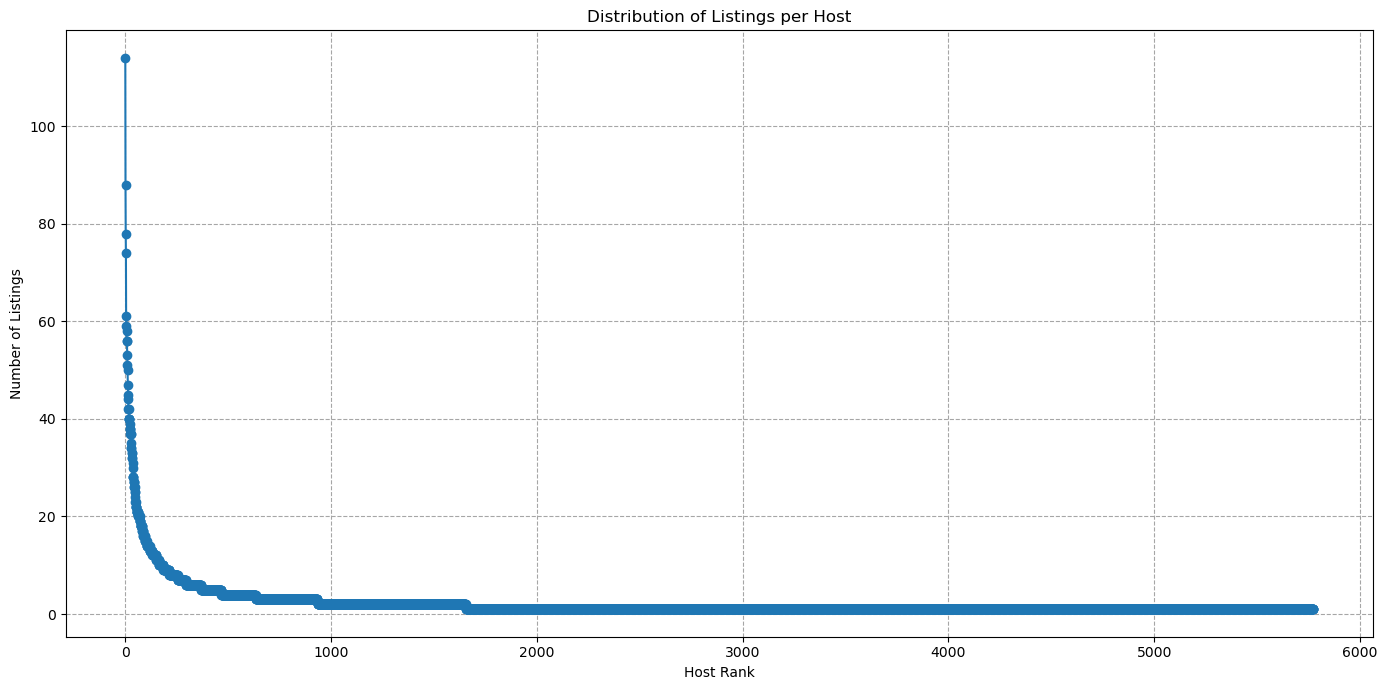

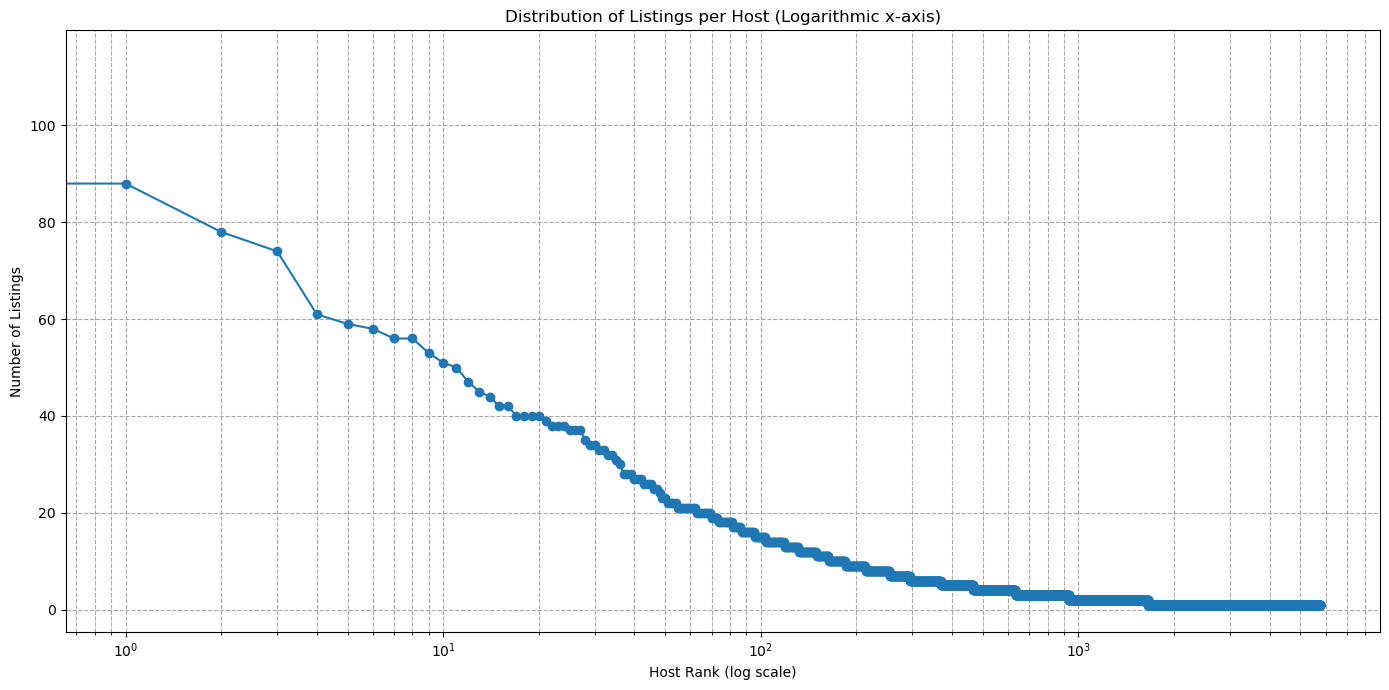

In [16]:
# Calculate Listings per Host
listings_per_host = data['host_id'].value_counts()

# Sort and Reset Index
listings_per_host = listings_per_host.reset_index()
listings_per_host.columns = ['host_id', 'number_of_listings']

# Plot the Data
plt.figure(figsize=(14, 7))
plt.plot(listings_per_host['number_of_listings'], marker='o', linestyle='-')
plt.title('Distribution of Listings per Host')
plt.xlabel('Host Rank')
plt.ylabel('Number of Listings')
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.show()

# Plot with Logarithmic x-axis
plt.figure(figsize=(14, 7))
plt.plot(listings_per_host['number_of_listings'], marker='o', linestyle='-')
plt.xscale('log')
plt.title('Distribution of Listings per Host (Logarithmic x-axis)')
plt.xlabel('Host Rank (log scale)')
plt.ylabel('Number of Listings')
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.show()

## Visualize Listings

Draw an interactive map to show the listings ovelayed on Athens.

You can use the [folium](https://github.com/python-visualization/folium) library to create your map; spend some time reading the documentation.

The map should show each listing and on clicking on top of it, the user should see a short description of the listing.

Note that such a map is heavy on resources. You will probably *not* be able to include it in a Jupyter notebook, so you should save it to an external HTML file that can be opened by any browser. Also, to make things easier, you make wish to limit the maximum zoom level from 12 to 15 (after you read folium's documentation you will know what this is).

Hint: be careful witht he description data, if they contain some characters they may not be rendered in HTML and may destroy your output.

In [17]:
#URL = 'http://insideairbnb.com/get-the-data.html'
response = requests.get(URL)

try:
    response.raise_for_status()

    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the link for the Athens geoJSON data
    athens_geojson_link = None
    for link in soup.find_all('a', href=True):
        if 'athens' in link['href'] and 'neighbourhoods.geojson' in link['href']:
            athens_geojson_link = link['href']
            break

    if athens_geojson_link:
        response = requests.get(athens_geojson_link, stream=True)
        with open('athens_neighbourhoods.geojson', 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print("Downloaded the Athens geoJSON data.")
    else:
        print("Could not find the Athens geoJSON data link.")

except requests.RequestException as error:
    print(f"Error fetching data from URL: {error}")


Downloaded the Athens geoJSON data.


In [18]:
import folium

# Set Up and Basic Map Creation
athens_center = [37.9838, 23.7275]
m = folium.Map(location=athens_center, zoom_start=12, max_zoom=15, min_zoom=12)

# Add Listings to the Map
for index, row in data.iterrows():
    # Clean the description to prevent any problematic characters (limiting to 50 characters for brevity)
    description = str(row['description']).replace('\n', '').replace('\r', '').replace('"', "'").strip()[:50] + '...'
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=description,
        icon=folium.Icon(icon="cloud"),
    ).add_to(m)

# Add the geoJSON layer for neighbourhoods
with open("athens_neighbourhoods.geojson", "r", encoding='utf-8') as file:
    geo_json_data = file.read()

folium.GeoJson(
    geo_json_data,
    name="geojson"
).add_to(m)

# Save the Map
m.save('athens_listings_map.html')
